# Differential-algebraic system of equations (DAE)

In [107]:
import jax
import jax.numpy as jnp
from autopdex import dae

jax.config.update("jax_enable_x64", True)

Here, we investigate the Robertson problem which models a set of chemical reactions:

$0 = -\frac{dy_1}{dt} -0.04\, y_1 + 10^4\, y_2 y_3$

$0 = -\frac{dy_2}{dt} + 0.04\, y_1 - 10^4\, y_2 y_3 - 3\cdot 10^7 \, y_2^2$

$0 = -\frac{dy_3}{dt} + 3\cdot 10^7 \, y_2^2$

The solution procedure can be done analogously to the Lotka-Volterra example, but we can also express the problem as a DAE by replacing the third equation with the constraint

$0 = 1 - y_1 - y_2 - y_3$

In [108]:
def dae_robertson(q_fun, t, settings):
  q_t_fun = jax.jacfwd(q_fun)
  q = q_fun(t)
  q_t = q_t_fun(t)

  y1 = q['y'][0]
  y2 = q['y'][1]
  y3 = q['y'][2]
  y1_t = q_t['y'][0]
  y2_t = q_t['y'][1]
  y3_t = q_t['y'][2]

  # Define the residuals
  res_y1 = y1_t - (-0.04 * y1 + 1e4 * y2 * y3)
  res_y2 = y2_t - (0.04 * y1 - 1e4 * y2 * y3 - 3e7 * y2**2)

  # res_y3 = y3_t - (3e7 * y2**2) # Implicit set of ODEs
  res_y3 = y1 + y2 + y3 - 1.0     # DAE

  return jnp.array([res_y1, res_y2, res_y3])


In case of DAEs, the choice of integrators is restricted. Currently, only integrators with solely implicit stages are compatible with algebraic equations. Further, the algebraic equations are enforced only at the stage positions. Consequently, nonlinear constraints may be violated at the final time of a time step. 

In [109]:
static_settings = {
    'dae': dae_robertson,
    'time integrators': {
        'y': dae.GaussLegendreRungeKutta(3)
    },
}

Run the initial value problem

In [110]:
dt0 = 1e-6
t_max = 1e4
num_time_steps = 100
dofs_0 = {
    'y': jnp.array([1., 0., 0.]),
}

manager = dae.TimeSteppingManager(
    static_settings,
    save_policy=dae.SaveAllPolicy(),
    step_size_controller=dae.RootIterationController(),
)

result = manager.run(dofs_0, dt0, t_max, num_time_steps)


Progress: 3%, Time: 3.64e+02, accepted step: True, dt: 9.10e+01, iterations: 3
Progress: 8%, Time: 8.89e+02, accepted step: True, dt: 2.22e+02, iterations: 3
Progress: 13%, Time: 1.39e+03, accepted step: True, dt: 3.47e+02, iterations: 3
Progress: 21%, Time: 2.17e+03, accepted step: True, dt: 5.79e+02, iterations: 2
Progress: 27%, Time: 2.75e+03, accepted step: True, dt: 7.72e+02, iterations: 2
Progress: 35%, Time: 3.52e+03, accepted step: True, dt: 1.03e+03, iterations: 2
Progress: 45%, Time: 4.55e+03, accepted step: True, dt: 1.37e+03, iterations: 2
Progress: 59%, Time: 5.92e+03, accepted step: True, dt: 1.83e+03, iterations: 2
Progress: 77%, Time: 7.75e+03, accepted step: True, dt: 2.44e+03, iterations: 2
Progress: 100%, Time: 1.00e+04, accepted step: True, dt: 3.00e+03, iterations: 2


Extract solution and visualize

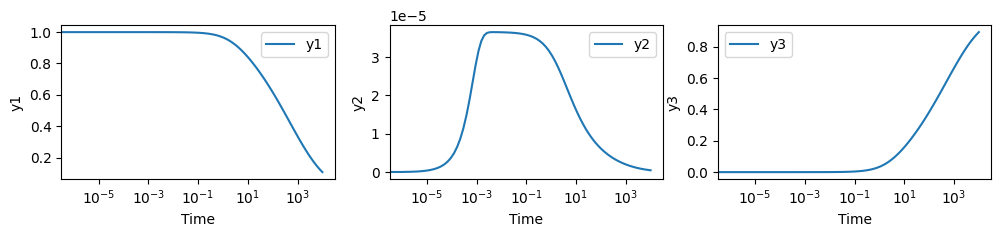

In [111]:
history = result.history
y1_sol = history.q['y'][:, 0]
y2_sol = history.q['y'][:, 1]
y3_sol = history.q['y'][:, 2]
ts = history.t

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(12, 2))
axs[0].plot(ts, y1_sol, label="y1")
axs[0].set_xscale("log")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("y1")
axs[0].legend()

axs[1].plot(ts, y2_sol, label="y2")
axs[1].set_xscale("log")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("y2")
axs[1].legend()

axs[2].plot(ts, y3_sol, label="y3")
axs[2].set_xscale("log")
axs[2].set_xlabel("Time")
axs[2].set_ylabel("y3")
axs[2].legend()

plt.show()
